In [0]:
%reset -f

In [2]:
!pip install pyldavis
!pip install guidedlda

     |████████████████████████████████| 1.6MB 2.7MB/s 
     |████████████████████████████████| 552kB 21.0MB/s 
  Created wheel for pyldavis: filename=pyLDAvis-2.1.2-py2.py3-none-any.whl size=97711 sha256=ac5b633a2791bf029ffa6e187ac13b1d12bd78b27ca6e055b3660dc2fe21cfa4
  Stored in directory: /root/.cache/pip/wheels/98/71/24/513a99e58bb6b8465bae4d2d5e9dba8f0bef8179e3051ac414
  Created wheel for funcy: filename=funcy-1.14-py2.py3-none-any.whl size=32042 sha256=739f56650995b17b8bc3d2595cf44b98dc1d4c6190638d550b679d0d5600f73b
  Stored in directory: /root/.cache/pip/wheels/20/5a/d8/1d875df03deae6f178dfdf70238cca33f948ef8a6f5209f2eb
Successfully built pyldavis funcy
     |████████████████████████████████| 2.1MB 2.7MB/s 
  Created wheel for guidedlda: filename=guidedlda-2.0.0.dev22-cp36-cp36m-linux_x86_64.whl size=2479746 sha256=045b6de9e203b4d1d46c3495ae8af4e04511b49be4d9819622563a08f720b3a8
  Stored in directory: /root/.cache/pip/wheels/cf/cb/c4/95897cbe4e2e12bd01db3c5cb004c744d2cfd68ecc692c

In [4]:
import pandas as pd
import numpy as np
import spacy
import gensim
import nltk 

from nltk.corpus import stopwords
nltk.download('stopwords')
from gensim.models import CoherenceModel, LdaModel, LsiModel, HdpModel
from gensim.models.wrappers import LdaMallet
from gensim.corpora import Dictionary
from gensim.utils import simple_preprocess
import pyLDAvis.gensim
#import seaborn as sns
#sns.set()
import os, re, operator, warnings
warnings.filterwarnings('ignore')  
#from google.colab import drive 
#drive.mount('/content/gdrive')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
# Read data 
#df= pd.read_csv("/content/gdrive/My Drive/Articles.csv",encoding= 'unicode_escape')
df= pd.read_csv("/content/Articles.csv",encoding= 'unicode_escape')

print(set(df['NewsType']))
df = df.drop(columns=['Date', 'Heading', 'NewsType'], axis=1)
#df = df.sample(100)
df.head(100)

{'business', 'sports'}


,Article
0,KARACHI: The Sindh government has decided to b...
1,HONG KONG: Asian markets started 2015 on an up...
2,HONG KONG: Hong Kong shares opened 0.66 perce...
3,HONG KONG: Asian markets tumbled Tuesday follo...
4,NEW YORK: US oil prices Monday slipped below $...
...,...
95,SINGAPORE: Oil prices fell on Monday as trader...
96,ISLAMABAD: The new price of petrol effective f...
97,KARACHI: Pakistans main stock index witnessed...
98,ISLAMABAD: The new price of petrol effective f...


In [7]:
#Pre-Processing 

# Remove punctuations
df['Article_Pre_Processed'] = df['Article'].map(lambda x: re.sub('[,\.!?]', '', x))

# Convert to lowercase
df['Article_Pre_Processed'] = df['Article_Pre_Processed'].map(lambda x: x.lower())

# Print 
df['Article_Pre_Processed'].head()

0    karachi: the sindh government has decided to b...
1    hong kong: asian markets started 2015 on an up...
2    hong kong:  hong kong shares opened 066 percen...
3    hong kong: asian markets tumbled tuesday follo...
4    new york: us oil prices monday slipped below $...
Name: Article_Pre_Processed, dtype: object

In [8]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data = df.Article_Pre_Processed.values.tolist()
data
#List of words
data_words = list(sent_to_words(data))

print(data_words[:1][0][:30])

['karachi', 'the', 'sindh', 'government', 'has', 'decided', 'to', 'bring', 'down', 'public', 'transport', 'fares', 'by', 'per', 'cent', 'due', 'to', 'massive', 'reduction', 'in', 'petroleum', 'product', 'prices', 'by', 'the', 'federal', 'government', 'geo', 'news', 'reportedsources']


In [0]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100)
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

#Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [0]:
#Saving stop-words from NLTK library
stop_words = stopwords.words('english')

In [0]:
# Functions for removing stopwords, making bigrams, trigrams and doing lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [12]:
# Using the created functions

#Remove Stopwords
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1][0][:30])

['government', 'decide', 'bring', 'public', 'transport', 'fare', 'due', 'massive', 'reduction', 'petroleum', 'product', 'price', 'federal', 'government', 'reportedsource', 'say', 'reduction', 'fare', 'applicable', 'public', 'transport', 'rickshaw', 'taxi', 'mean', 'refuse', 'abide', 'government', 'irshad', 'say', 'commuter']


In [13]:
import gensim.corpora as corpora
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
# View
print(corpus[:1][0][:30])
#corpus.shape

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 4), (13, 1), (14, 3), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 2), (24, 1), (25, 2), (26, 2), (27, 1), (28, 1), (29, 1)]


In [14]:
#Making the LSI Model
lsimodel = LsiModel(corpus=corpus, num_topics=10, id2word=id2word)
lsimodel.show_topics()

[(0,
  '0.496*"say" + 0.353*"percent" + 0.270*"year" + 0.164*"market" + 0.159*"oil" + 0.152*"price" + 0.138*"also" + 0.132*"last" + 0.132*"strong" + 0.118*"would"'),
 (1,
  '0.498*"percent" + -0.224*"test" + -0.211*"say" + -0.188*"first" + -0.177*"match" + -0.172*"play" + 0.166*"market" + 0.164*"oil" + 0.163*"price" + -0.161*"team"'),
 (2,
  '-0.576*"say" + 0.263*"percent" + 0.222*"first" + 0.201*"run" + 0.191*"test" + 0.190*"wicket" + 0.170*"ball" + -0.143*"government" + 0.142*"match" + 0.130*"second"'),
 (3,
  '-0.557*"oil" + 0.490*"percent" + -0.381*"price" + -0.196*"crude" + -0.154*"production" + -0.146*"output" + -0.120*"market" + -0.115*"cent" + -0.098*"cut" + -0.094*"demand"'),
 (4,
  '-0.326*"run" + -0.321*"wicket" + -0.272*"ball" + 0.225*"team" + 0.211*"play" + 0.202*"player" + -0.178*"government" + 0.168*"cricket" + 0.151*"world" + 0.150*"year"'),
 (5,
  '0.601*"year" + -0.297*"say" + 0.219*"rs_billion" + 0.219*"last" + 0.200*"export" + 0.155*"borrower" + -0.150*"team" + 0.14

In [15]:
#Making the HDP Model
hdpmodel = HdpModel(corpus=corpus, id2word=id2word)
hdpmodel.show_topics()

[(0,
  '0.018*say + 0.010*year + 0.008*first + 0.007*strong + 0.007*percent + 0.006*make + 0.006*test + 0.006*last + 0.006*also + 0.006*take + 0.005*team + 0.005*match + 0.005*play + 0.005*run + 0.005*would + 0.004*time + 0.004*world + 0.004*wicket + 0.004*country + 0.004*day'),
 (1,
  '0.016*say + 0.009*year + 0.007*percent + 0.007*oil + 0.006*strong + 0.006*price + 0.005*also + 0.005*first + 0.005*market + 0.005*last + 0.004*month + 0.004*take + 0.004*country + 0.004*world + 0.004*make + 0.004*match + 0.004*would + 0.003*fall + 0.003*day + 0.003*week'),
 (2,
  '0.008*percent + 0.007*say + 0.004*year + 0.004*market + 0.003*economy + 0.003*first + 0.003*job + 0.003*fall + 0.003*also + 0.003*price + 0.003*strong + 0.003*oil + 0.003*match + 0.002*last + 0.002*world + 0.002*run + 0.002*rise + 0.002*wicket + 0.002*add + 0.002*low'),
 (3,
  '0.008*say + 0.007*percent + 0.004*year + 0.003*strong + 0.003*market + 0.003*also + 0.002*price + 0.002*trade + 0.002*last + 0.002*would + 0.002*dollar

In [16]:
#Making the LDA Model
# corpus.shape
ldamodel = LdaModel(corpus=corpus, num_topics=10, id2word=id2word)
ldamodel.show_topics()

[(0,
  '0.015*"say" + 0.009*"test" + 0.008*"strong" + 0.007*"first" + 0.007*"day" + 0.006*"time" + 0.006*"year" + 0.005*"second" + 0.005*"take" + 0.005*"make"'),
 (1,
  '0.010*"first" + 0.009*"take" + 0.009*"second" + 0.008*"make" + 0.008*"run" + 0.007*"time" + 0.007*"score" + 0.007*"year" + 0.006*"woman" + 0.006*"last"'),
 (2,
  '0.017*"say" + 0.015*"year" + 0.009*"first" + 0.009*"strong" + 0.009*"test" + 0.008*"team" + 0.007*"player" + 0.007*"take" + 0.007*"time" + 0.006*"last"'),
 (3,
  '0.024*"say" + 0.015*"year" + 0.014*"percent" + 0.009*"country" + 0.007*"strong" + 0.006*"last" + 0.006*"also" + 0.006*"would" + 0.005*"month" + 0.004*"government"'),
 (4,
  '0.027*"percent" + 0.012*"say" + 0.012*"market" + 0.007*"last" + 0.007*"strong" + 0.006*"high" + 0.006*"rise" + 0.006*"oil" + 0.006*"dollar" + 0.005*"investor"'),
 (5,
  '0.018*"say" + 0.011*"percent" + 0.010*"oil" + 0.009*"year" + 0.009*"price" + 0.007*"strong" + 0.007*"would" + 0.006*"also" + 0.006*"country" + 0.006*"last"'),
 

In [17]:
#Making the LDA Model with 3 topics
ldamodel_3_topics = LdaModel(corpus=corpus, num_topics=3, id2word=id2word)
ldamodel_3_topics.show_topics()

[(0,
  '0.010*"first" + 0.010*"year" + 0.009*"test" + 0.008*"say" + 0.007*"make" + 0.007*"run" + 0.006*"strong" + 0.006*"match" + 0.006*"day" + 0.006*"wicket"'),
 (1,
  '0.021*"say" + 0.017*"percent" + 0.009*"oil" + 0.008*"year" + 0.008*"market" + 0.008*"strong" + 0.007*"last" + 0.007*"country" + 0.007*"also" + 0.006*"price"'),
 (2,
  '0.020*"say" + 0.011*"year" + 0.010*"first" + 0.009*"test" + 0.008*"strong" + 0.007*"team" + 0.007*"play" + 0.007*"take" + 0.006*"match" + 0.006*"make"')]

In [18]:
pyLDAvis.enable_notebook()
pyLDAvis.gensim.prepare(ldamodel, corpus, id2word)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
9      0.107609 -0.014271       1        1  25.382847
8     -0.110691  0.029439       2        1  20.154997
3     -0.057947 -0.058287       3        1  19.066822
2      0.052343 -0.028311       4        1  10.430660
4     -0.066980  0.032505       5        1   5.131356
5     -0.042696  0.006347       6        1   4.860934
6      0.071851 -0.001429       7        1   4.707202
0      0.051823 -0.020392       8        1   4.114303
1      0.076765  0.069070       9        1   3.389772
7     -0.082076 -0.014671      10        1   2.761111, topic_info=        Term         Freq        Total Category  logprob  loglift
160  percent  2631.000000  2631.000000  Default  30.0000  30.0000
157      oil  1754.000000  1754.000000  Default  29.0000  29.0000
31       say  5691.000000  5691.000000  Default  28.0000  28.0000
108    first  2156.000000  2156.000000  Default  27.0000  27.0000
23     price  1601.000000  1601.000000  Default  26.0000  26.0000
..       ...          ...          ...      ...      ...      ...
228      new    25.540768   704.414062  Topic10  -5.8018   0.2724
249      day    26.688400  1149.101562  Topic10  -5.7579  -0.1730
172   report    22.755228   603.893494  Topic10  -5.9173   0.3109
119     high    22.871473  1098.252319  Topic10  -5.9122  -0.2820
208     time    22.792212  1284.034790  Topic10  -5.9157  -0.4418

[841 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
0         4  0.746561      abide
7837      6  0.712240  accessory
7778      3  0.050506   accident
7778      4  0.050506   accident
7778      8  0.808102   accident
...     ...       ...        ...
223       8  0.003834        yen
223       9  0.011501        yen
223      10  0.003834        yen
6679      5  0.700233        yoy
4163      5  0.907520     zubair

[2630 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[10, 9, 4, 3, 5, 6, 7, 1, 2, 8])

In [0]:
lsitopics = [[word for word, prob in topic] for topicid, topic in lsimodel.show_topics(formatted=False)]

In [0]:
hdptopics = [[word for word, prob in topic] for topicid, topic in hdpmodel.show_topics(formatted=False)]

In [0]:
ldatopics = [[word for word, prob in topic] for topicid, topic in ldamodel.show_topics(formatted=False)]

In [22]:
lsi_coherence = CoherenceModel(topics=lsitopics[:10], texts=texts, dictionary=id2word, window_size=10).get_coherence()
print("The value of LSI coherence Score:", lsi_coherence)

The value of LSI coherence Score: 0.3268514959668464


In [23]:
hdp_coherence = CoherenceModel(topics=hdptopics[:10], texts=texts, dictionary=id2word, window_size=10).get_coherence()
print("The value of HDP coherence Score:",hdp_coherence)

The value of HDP coherence Score: 0.3310572079988744


In [24]:
lda_coherence = CoherenceModel(topics=ldatopics, texts=texts, dictionary=id2word, window_size=10).get_coherence()
print("The value of LDA coherence Score :", lda_coherence)

The value of LDA coherence Score : 0.41115166186858254


In [0]:
import matplotlib.pyplot as plt
def evaluate_bar_graph(coherences, indices):
    assert len(coherences) == len(indices)
    n = len(coherences)
    x = np.arange(n)
    plt.bar(x, coherences,  tick_label=indices, align='center',color=['grey', 'green', 'blue'])
    csfont = {'fontname':'Comic Sans MS'}
    #hfont = {'fontname':'Helvetica'}
    plt.xlabel('TOPIC MODELS',color="RED",**csfont)
    plt.ylabel('COHERENCE VALUES',color="GREEN",**csfont)

findfont: Font family ['Comic Sans MS'] not found. Falling back to DejaVu Sans.


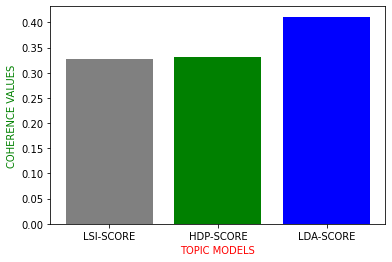

In [26]:
evaluate_bar_graph([lsi_coherence, hdp_coherence, lda_coherence],
['LSI-SCORE', 'HDP-SCORE', 'LDA-SCORE'])

In [0]:
##### GUIDED LDA #######
#### Semi Supervised Approach to Topic Modeling using Guided LDA ####

In [0]:
import guidedlda

In [29]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(df['Article_Pre_Processed'])
#word2id = dict((v, idx) for idx, v in enumerate(df['Article_Pre_Processed']))
X = np.transpose(X)
print(type(X))
X=(X.toarray())
X.shape
print(type(X))
final_list = []
for list in texts:
  final_list = final_list+list

fl = set(final_list)
print("asdfasdfa",len(fl))
word2id = dict((v, idx) for idx, v in enumerate(final_list))

#Regular LDA Model to see the topics
model_unguided = guidedlda.GuidedLDA(n_topics=10, n_iter=100, random_state=7, refresh=20)
model_unguided.fit(X)
model_unguided.word_topic_

<class 'scipy.sparse.csc.csc_matrix'>
<class 'numpy.ndarray'>


INFO:guidedlda:n_documents: 42490
INFO:guidedlda:vocab_size: 2692
INFO:guidedlda:n_words: 783682
INFO:guidedlda:n_topics: 10
INFO:guidedlda:n_iter: 100


asdfasdfa 18677


INFO:guidedlda:<0> log likelihood: -8362543
INFO:guidedlda:<20> log likelihood: -6599722
INFO:guidedlda:<40> log likelihood: -6441804
INFO:guidedlda:<60> log likelihood: -6378726
INFO:guidedlda:<80> log likelihood: -6342315
INFO:guidedlda:<99> log likelihood: -6322855


array([[9.51474786e-05, 9.51474786e-05, 9.51474786e-05, ...,
        9.51474786e-05, 9.51474786e-05, 1.80875357e-01],
       [1.36035913e-05, 1.36035913e-05, 6.31220242e-01, ...,
        1.36035913e-05, 2.14950347e-01, 1.36035913e-05],
       [5.56786704e-02, 2.77008310e-04, 9.42105263e-01, ...,
        2.77008310e-04, 2.77008310e-04, 2.77008310e-04],
       ...,
       [3.24569945e-05, 9.09120415e-02, 3.24569945e-05, ...,
        3.24569945e-05, 3.37585200e-01, 5.71275560e-01],
       [3.40020401e-05, 3.40020401e-05, 3.40020401e-05, ...,
        3.40020401e-05, 1.36042163e-01, 2.04352261e-02],
       [9.59867388e-02, 1.72762171e-01, 1.74489618e-05, ...,
        1.74489618e-05, 1.74489618e-05, 2.02425406e-01]])

In [30]:
topic_word = model_unguided.topic_word_
n_top_words = 10
for i, topic_dist in enumerate(topic_word):
     topic_words = np.array(final_list)[np.argsort(topic_dist)][:-(n_top_words+1):-1]
     print('Topic {}: {}'.format(i, ' '.join(topic_words)))

Topic 0: percent percent displace supply programme producer plunge price late tradingeye
Topic 1: chairmanship crisis committee multi rise meet bank againanalyst time arise
Topic 2: email cut crude cost energy commodity index decide percent eurozoneoil
Topic 3: datum fuel time immediately half also company stock negative contraction
Topic 4: seek datum lose confirm blame world percent appear fail rating
Topic 5: fall crude development crisis start oil say asian future datum
Topic 6: report half day pressure visible commodity erode output customer paec
Topic 7: bond_buye accord import minister ecc make available come monetary oil
Topic 8: breach crude delivery even approach year rating see buy year
Topic 9: affect improve risk say oil start development crude dip mismanagement


In [31]:
#Guided LDA Model
#Seed topic list to guide the model
seed_topic_list = [['datum','lose','corporate', 'fuel', 'rent', 'company', 'affect', 'risk'],
                   ['crude', 'share','market','oil', 'cut', 'index', 'loss', 'sink', 'slip'],
                   ['note', 'accord','committee','displace','crisis','government','management']]
model_guided = guidedlda.GuidedLDA(n_topics=10, n_iter=100, random_state=7, refresh=20)

seed_topics = {}
for t_id, st in enumerate(seed_topic_list):
    for word in st:
        seed_topics[word2id[word]] = t_id

model_guided.fit(X, seed_topics=seed_topic_list, seed_confidence=0.50)

n_top_words = 10
topic_word = model_guided.topic_word_
for i, topic_dist in enumerate(topic_word):
    topic_words = np.array(final_list)[np.argsort(topic_dist)][:-(n_top_words+1):-1]
    print('Topic {}: {}'.format(i, ' '.join(topic_words)))

INFO:guidedlda:n_documents: 42490
INFO:guidedlda:vocab_size: 2692
INFO:guidedlda:n_words: 783682
INFO:guidedlda:n_topics: 10
INFO:guidedlda:n_iter: 100
INFO:guidedlda:<0> log likelihood: -8362543
INFO:guidedlda:<20> log likelihood: -6599722
INFO:guidedlda:<40> log likelihood: -6441804
INFO:guidedlda:<60> log likelihood: -6378726
INFO:guidedlda:<80> log likelihood: -6342315
INFO:guidedlda:<99> log likelihood: -6322855


Topic 0: percent percent displace supply programme producer plunge price late tradingeye
Topic 1: chairmanship crisis committee multi rise meet bank againanalyst time arise
Topic 2: email cut crude cost energy commodity index decide percent eurozoneoil
Topic 3: datum fuel time immediately half also company stock negative contraction
Topic 4: seek datum lose confirm blame world percent appear fail rating
Topic 5: fall crude development crisis start oil say asian future datum
Topic 6: report half day pressure visible commodity erode output customer paec
Topic 7: bond_buye accord import minister ecc make available come monetary oil
Topic 8: breach crude delivery even approach year rating see buy year
Topic 9: affect improve risk say oil start development crude dip mismanagement
